<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2023notebooks/2023Sharkar_Build_your_own_Transformer_from_scratch_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!gls -lt *.ipynb | head

# [Build your own Transformer from scratch using Pytorch](https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb)

このチュートリアルでは PyTorch を使用して基本的な Transformer モデルをゼロから構築する。
Transformer モデルは Vaswani+ が論文 Attention is All You Need で導入したもので，機械翻訳やテキスト要約などの seq2seq 課題のために設計された深層学習アーキテクチャである。
自己注意機構に基づいており，GPT や BERT など，多くの最先端の自然言語処理モデルの基盤となっている。
<!-- In this tutorial, we will build a basic Transformer model from scratch using PyTorch. 
The Transformer model, introduced by Vaswani et al. in the paper “Attention is All You Need,” is a deep learning architecture designed for sequence-to-sequence tasks, such as machine translation and text summarization. 
It is based on self-attention mechanisms and has become the foundation for many state-of-the-art natural language processing models, like GPT and BERT. -->

Transformer の詳細は，以下の 2 記事を参照: 
<!-- To understand Transformer models in detail kindly visit these two articles: -->

1. [All you need to know about ‘Attention’ and ‘Transformers’ — In-depth Understanding — Part 1](https://medium.com/towards-data-science/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-1-552f0b41d021)
2. [All you need to know about ‘Attention’ and ‘Transformers’ — In-depth Understanding — Part 2](https://medium.com/towards-data-science/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-2-bf2403804ada)

Transformer モデルの作成においては以下の段階を踏む:<!-- To build our Transformer model, we’ll follow these steps:-->

1.  必要なライブラリやモジュールをインポートする
2.  基本的な構成要素を定義する: マルチヘッド注意，位置ごとのフィードフォワードネットワーク，および，位置符号化器
3. 符号化器と復号化器の層を構築
4. 符号化器と復号化器の層を組み合わせて，完全な transformer モデルを作成する。
5. サンプルデータの作成
6. モデルの訓練

<!--1. Import necessary libraries and modules
2. Define the basic building blocks: Multi-Head Attention, Position-wise Feed-Forward Networks, Positional Encoding
3. Build the Encoder and Decoder layers
4. Combine Encoder and Decoder layers to create the complete Transformer model
5. Prepare sample data
6. Train the model -->

まずは必要なライブラリやモジュールをインポートするところから始めよう。
<!-- Let’s start by importing the necessary libraries and modules. -->

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

Transformer モデルの基本的な構成要素を定義する:
<!-- Now, we’ll define the basic building blocks of the Transformer model. -->

## 1. マルチヘッド注意 <!-- ## Multi-Head Attention-->

<center>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*--TCGWYxwASbv2ra.png" width="33%"><br/>
図 1. マルチヘッド注意
<!-- Figure 2. Multi-Head Attention (source: image created by author) -->
</center>

マルチヘッド注意機構は，系列内の各対の位置間の注意を計算する。
これは，入力系列の異なる側面を捉える複数の `注意ヘッド` で構成される。
<!-- The Multi-Head Attention mechanism computes the attention between each pair of positions in a sequence. 
It consists of multiple “attention heads” that capture different aspects of the input sequence. -->

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, 
                 d_model:int,    # 各層の素子数
                 num_heads:int   # ヘッド数，マルチヘッド注意の定義に必要
                ):
        super().__init__()
        assert d_model % num_heads == 0, "d_model は num_heads で割り切れる数である必要がある"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model)
        self.W_o = nn.Linear(in_features=d_model, out_features=d_model)
        
    def scaled_dot_product_attention(self, 
                                     Q:torch.Tensor, 
                                     K:torch.Tensor, 
                                     V:torch.Tensor, 
                                     mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask==0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, 
                    x:torch.Tensor):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, 
                      x:torch.Tensor):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, 
                Q:torch.Tensor, 
                K:torch.Tensor, 
                V:torch.Tensor, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

MultiHeadAttention のコードは，入力パラメータと線形変換層でモジュールを初期化する。
注意得点を計算し，入力テンソルを複数のヘッドに再整形し，すべてのヘッドからの注意出力を結合する。
`forward` メソッドはマルチヘッド自己注意を計算し，モデルが入力系列の別の面に注意を向けることを可能にする。
<!-- The MultiHeadAttention code initializes the module with input parameters and linear transformation layers. 
It calculates attention scores, reshapes the input tensor into multiple heads, and combines the attention outputs from all heads. 
The forward method computes the multi-head self-attention, allowing the model to focus on some different aspects of the input sequence. -->

## 位置ごとのフィードフォワードネットワーク Position-wise_FeedForward_Networks

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, 
                 d_model:int, 
                 d_ff:int):
        super().__init__()
        self.fc1 = nn.Linear(in_features=d_model, out_features=d_ff)
        self.fc2 = nn.Linear(in_features=d_ff, out_features=d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        #return self.fc2(self.relu(self.fc1(x)))

`PositionWiseFeedForward` クラスは、PyTorchの `nn.Module` を拡張し，位置ごとのフィードフォワードネットワークの実装である。
このクラスは，2 つの線形変換層と ReLU 活性化関数で初期化される。
`forward` メソッドは，これらの変換と活性化関数を順次適用して出力を計算する。
この処理により，モデルは入力要素の位置を考慮しながら予測を行うことができる。
<!-- The PositionWiseFeedForward class extends PyTorch’s `nn.Module` and implements a position-wise feed-forward network. 
The class initializes with two linear transformation layers and a ReLU activation function. 
The forward method applies these transformations and activation function sequentially to compute the output. 
This process enables the model to consider the position of input elements while making predictions. -->

## 位置符号化器 Positional Encoding

位置符号化は，入力系列の各トークンの位置情報を挿入するために使用される。
異なる周波数の正弦波関数と余弦波関数を使用して位置情報を生成する。
<!--Positional Encoding is used to inject the position information of each token in the input sequence. 
It uses sine and cosine functions of different frequencies to generate the positional encoding. -->

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, 
                 d_model:int, 
                 max_seq_length:int):
        super().__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

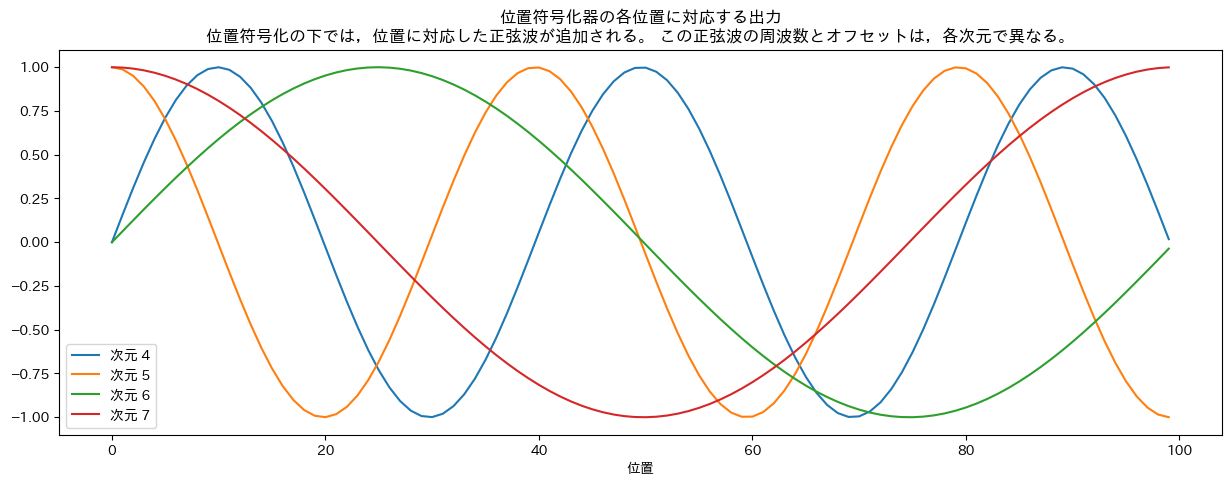

In [ ]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.

from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib
    
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(d_model=20, max_seq_length=500)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend([f"次元 {p}" for p in [4,5,6,7]])
plt.title('位置符号化器の各位置に対応する出力\n位置符号化の下では，位置に対応した正弦波が追加される。 この正弦波の周波数とオフセットは，各次元で異なる。')
plt.xlabel('位置')
plt.show()
#None

`PositionalEncoding` クラスは，入力パラメータ `d_model` と `max_seq_length` で初期化し，位置符号化器の値を格納するテンソルを作成する。
このクラスは，スケール因子 `div_term` に基づいて，偶数インデックスと奇数インデックスの正弦波と余弦波の値をそれぞれ計算する。
forward メソッドは，格納された位置符号化値を入力テンソルに追加することで位置符号化を計算し，モデルが入力配列の位置情報を捕捉できるようにする。
<!-- The PositionalEncoding class initializes with input parameters `d_model` and `max_seq_length`, creating a tensor to store positional encoding values. 
The class calculates sine and cosine values for even and odd indices, respectively, based on the scaling factor div_term. 
The forward method computes the positional encoding by adding the stored positional encoding values to the input tensor, allowing the model to capture the position information of the input sequence. -->

では，符号化器と復号化器の層を構築する。
<!-- Now, we’ll build the Encoder and Decoder layers. -->

## 符号化器層 Encoder Layer

<center>
<img src="https://miro.medium.com/v2/resize:fit:552/format:webp/0*bPKV4ekQr9ZjYkWJ.png" width="18%"><br/>
図 3. transformer ネットワークの符号化器部分
<!-- Figure 3. The Encoder part of the transformer network (Source: image from the original paper) -->
</center>

符号化器層は，マルチヘッド注意層，位置ごとのフィードフォワード層，2 つの層正規化層で構成される。
<!-- An Encoder layer consists of a Multi-Head Attention layer, a Position-wise Feed-Forward layer, and two Layer Normalization layers. -->


In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

EncoderLayer クラスは，入力パラメータと，`MultiHeadAttention` モジュール，`PositionWiseFeedForward` モジュール，2 つの層正規化モジュール，ドロップアウト層などの成分で初期化する。
forward メソッドは，自己注意を適用して符号化層の出力を計算し，注意出力を入力テンソルに加え，その結果を正規化する。
次に，位置ごとのフィードフォワード出力を計算し，正規化された自己注意出力と結合し，最終結果を正規化してから処理されたテンソルを返す。
<!-- The EncoderLayer class initializes with input parameters and components, including a `MultiHeadAttention` module, a `PositionWiseFeedForward` module, two layer normalization modules, and a dropout layer. 
The forward methods computes the encoder layer output by applying self-attention, adding the attention output to the input tensor, and normalizing the result. 
Then, it computes the position-wise feed-forward output, combines it with the normalized self-attention output, and normalizes the final result before returning the processed tensor.-->

## 復号化器層 Decoder Layer

<center>
<img src="https://miro.medium.com/v2/resize:fit:552/format:webp/0*SPZgT4k8GQi37H__.png" width="18%"><br/>
図 4. Transformer ネットワークの復号化器部分    
<!-- Figure 4. The Decoder part of the Transformer network (Souce: Image from the original paper) -->
</center>

復号化器層は，2 つのマルチヘッド注意層，位置ごとのフィードフォワード層，3 つの層正規化層で構成される。
<!-- A Decoder layer consists of two Multi-Head Attention layers, a Position-wise Feed-Forward layer, and three Layer Normalization layers. -->

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

復号化器層は，入力パラメータと，マスクされた自己注意と交差注意のためのマルチヘッド注意モジュール，位置ごとのフィードフォワードモジュール，3  層の正規化モジュール，およびドロップアウト層などの成分で初期化する。
<!-- The DecoderLayer initializes with input parameters and components such as MultiHeadAttention modules for masked self-attention and cross-attention, a PositionWiseFeedForward module, three layer normalization modules, and a dropout layer.-->

forward メソッドは，以下のステップを実行することで，復号化器層の出力を計算する:
<!-- The forward method computes the decoder layer output by performing the following steps: -->

1. マスクされた自己注意出力を計算し，入力テンソルに加算した後，ドロップアウトと層正規化を行う。
2. 復号化器出力と符号化器出力の間の交差注意出力を計算し，正規化されたマスクされた自己注意出力に加え，ドロップアウトと層正規化を行う。
3. 位置ごとのフィードフォワード出力を計算し，正規化された交差注意出力に加え，ドロップアウトと層正規化を行う。
4. 処理されたテンソルを返す。

<!-- 1. Calculate the masked self-attention output and add it to the input tensor, followed by dropout and layer normalization.
2. Compute the cross-attention output between the decoder and encoder outputs, and add it to the normalized masked self-attention output, followed by dropout and layer normalization.
3. Calculate the position-wise feed-forward output and combine it with the normalized cross-attention output, followed by dropout and layer normalization.
4. Return the processed tensor. -->

これらの操作により，復号化は入力と符号化出力に基づいて標的系列を生成することができる。
<!-- These operations enable the decoder to generate target sequences based on the input and the encoder output.-->

さて，符号化器と復号化器の層を組み合わせて，完全な transformer モデルを作る。
<!--Now, let’s combine the Encoder and Decoder layers to create the complete Transformer model.
 -->
## Transformer Model

<center>
<img src="https://miro.medium.com/v2/resize:fit:1090/format:webp/0*ljYs7oOlKC71SzSr.png" width="33%"><br/>
Figure 5. The Transformer Network (Source: Image from the original paper)
</center>

Merging it all together:

In [ ]:
class Transformer(nn.Module):
    def __init__(self, 
                 src_vocab_size, 
                 tgt_vocab_size, 
                 d_model, 
                 num_heads, 
                 num_layers, 
                 d_ff, 
                 max_seq_length, 
                 dropout):
        super().__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output


Transformer クラスは，先に定義されたモジュールを組み合わせて，完全な Transformer モデルを作成する。
初期化の際，Transformer モジュールは入力パラメータを設定し，ソースとターゲット系列用の埋め込み層，PositionalEncoding モジュール，スタック層を作成する EncoderLayer とDecoderLayer モジュール，復号化器出力を映し出すための線形層，ドロップアウト層など様々な成分を初期化する。
<!-- The Transformer class combines the previously defined modules to create a complete Transformer model. 
During initialization, the Transformer module sets up input parameters and initializes various components, including embedding layers for source and target sequences, a PositionalEncoding module, EncoderLayer and DecoderLayer modules to create stacked layers, a linear layer for projecting decoder output, and a dropout layer. -->

generate_mask メソッドは，パディングトークンを無視し，復号化器が将来のトークンに注目しないように，ソースとターゲット系列に二値化マスクを作成する。
forward メソッドは，以下のステップで Transformer モデルの出力を計算する：
<!-- The generate_mask method creates binary masks for source and target sequences to ignore padding tokens and prevent the decoder from attending to future tokens. 
The forward method computes the Transformer model’s output through the following steps: -->

1. generate_maskメソッドでソースマスクとターゲットマスクを生成する。
2. ソースとターゲットの埋め込みを計算し，位置符号化とドロップアウトを適用する。
3. ソース系列を符号化層で処理し，enc_output テンソルを更新する。
4. 符号化出力とマスクを用いて，ターゲット系列を復号化器層で処理し，dec_output テンソルを更新する。
5. 復号化器出力に線形射影層を適用し，出力ロジットを得る。

<!-- 1. Generate source and target masks using the generate_mask method.
2. Compute source and target embeddings, and apply positional encoding and dropout.
3. Process the source sequence through encoder layers, updating the enc_output tensor.
4. Process the target sequence through decoder layers, using enc_output and masks, and updating the dec_output tensor.
5. Apply the linear projection layer to the decoder output, obtaining output logits.-->

これらのステップにより，Transformer モデルは，成分の組み合わせ機能に基づいて，入力系列を処理し，出力系列を生成することができる。
<!--These steps enable the Transformer model to process input sequences and generate output sequences based on the combined functionality of its components. -->

## サンプルデータの準備 Preparing Sample Data

この例では，デモ用におもちゃのデータセットを作成する。
実際には，より大きなデータセットを使用し，テキストを前処理し，ソース言語とターゲット言語の語彙写像を作成することになる。
<!-- In this example, we will create a toy dataset for demonstration purposes. 
In practice, you would use a larger dataset, preprocess the text, and create vocabulary mappings for source and target languages. -->

In [ ]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

## モデルの訓練 Training the Model

では，サンプルデータを使ってモデルを訓練してみよう。
実際には，もっと大きなデータセットを使って，訓練セットと検証セットに分けることになる。
<!-- Now we’ll train the model using the sample data. 
In practice, you would use a larger dataset and split it into training and validation sets. -->


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1:3d}, Loss: {loss.item():.3f}")

Epoch:   1, Loss: 8.675
Epoch:   2, Loss: 8.544
Epoch:   3, Loss: 8.477
Epoch:   4, Loss: 8.420
Epoch:   5, Loss: 8.359
Epoch:   6, Loss: 8.284
Epoch:   7, Loss: 8.205
Epoch:   8, Loss: 8.122
Epoch:   9, Loss: 8.038
Epoch:  10, Loss: 7.958
Epoch:  11, Loss: 7.881
Epoch:  12, Loss: 7.796
Epoch:  13, Loss: 7.714
Epoch:  14, Loss: 7.624
Epoch:  15, Loss: 7.540
Epoch:  16, Loss: 7.461
Epoch:  17, Loss: 7.371
Epoch:  18, Loss: 7.292
Epoch:  19, Loss: 7.213
Epoch:  20, Loss: 7.127
Epoch:  21, Loss: 7.049
Epoch:  22, Loss: 6.969
Epoch:  23, Loss: 6.889
Epoch:  24, Loss: 6.823
Epoch:  25, Loss: 6.746
Epoch:  26, Loss: 6.674
Epoch:  27, Loss: 6.592
Epoch:  28, Loss: 6.518
Epoch:  29, Loss: 6.448
Epoch:  30, Loss: 6.374
Epoch:  31, Loss: 6.304
Epoch:  32, Loss: 6.237
Epoch:  33, Loss: 6.167
Epoch:  34, Loss: 6.099
Epoch:  35, Loss: 6.030
Epoch:  36, Loss: 5.971
Epoch:  37, Loss: 5.910
Epoch:  38, Loss: 5.843
Epoch:  39, Loss: 5.782
Epoch:  40, Loss: 5.729
Epoch:  41, Loss: 5.656
Epoch:  42, Loss

この方法を使えば，Pytorch でゼロから簡単な Transformer を構築することができる。
すべての大規模言語モデルは，これらの Transformer 符号器または復号化器ブロックを学習に使用する。
したがって，すべてを開始したネットワークを理解することは非常に重要である。
この記事が LLM に深入しようとする皆の役に立つことを願っている。
<!-- We can use this way to build a simple Transformer from scratch in Pytorch. 
All Large Language Models use these Transformer encoder or decoder blocks for training. 
Hence understanding the network that started it all is extremely important. 
Hope this article helps all looking to deep dive into LLM’s. -->

## References

* [Attention is all you need, A. Vaswani, N. Shazeer, N. Parmar, J. Uszkoreit, L. Jones, A. Gomez, {. Kaiser, and I. Polosukhin. Advances in Neural Information Processing Systems , page 5998–6008. (2017)](https://www.bibsonomy.org/person/1c9bf08cbcb15680c807e12a01dd8c929/author/1)